# Black Panther: Market Survey Analysis and Findings

## Summary:
Disney studios is commissioning a new superhero theme park in Florida. They’ve narrowed the choices to Black Panther and Iron Man and will build a park based the number of Floridians who purchase either movie’s merchandise at local Disney stores this year. In general, people only tend to buy one movie’s merchandise. As part of our partnership with the Black Panther production team, we've analyzed potential strategies to convince Floridians to purchase Black Panther merchandise. 
Back in December, our data science team built a superhero preference score for every potential consumer in Florida.  The score measures two-way support, meaning that if someone is scored as a 64 they have a 64% likelihood of preferring Black Panther and a 36% likelihood of preferring Iron Man. 
The survey team recently conducted a poll to measure superhero preferences among Floridians. They weighted the results to likely Disney store shoppers and sent you the weights for everyone who responded to the survey and whose identity they could verify, along with the raw phone results and the sample the survey was pulled from. 

In this document I'll take you step-by-step through our analysis of the polling data, and suggest areas where our modeling may need to be updated.

### Part 1: Load
In this section I load some useful software packages, read the data into memory, and do some basic examination of the dataset.

In [4]:
# Import standard packages
import numpy as np
import pandas as pd
import sklearn as sk

In [5]:
# Read the tab-delimited data files and examine
raw = pd.read_csv('Returns.txt', delimiter="\t",
                 low_memory=False)

df = pd.read_csv('Sample.txt', delimiter="\t",
                 low_memory=False)
df.head().T;

In [6]:
weights = pd.read_csv('Weights.txt', delimiter="\t")
weights.head().T

,0,1,2,3,4
ID,6.492648e+08,6.554264e+08,6.852681e+08,6.883162e+08,6.947868e+08
weight,7.294788e-01,1.990314e+00,6.954376e-01,8.820481e-01,1.117857e+00


In [7]:
# I don't need separate DataFrames. Merge
df = pd.merge(df, weights, on="ID", how="outer")

In [8]:
df.shape

(134226, 19)

In [9]:
weights.shape

(973, 2)

In [10]:
df.columns

Index(['ID', 'demo_age', 'demo_age_bucket', 'case', 'movie_seen', 'demo_sex',
       'demo_city', 'demo_zipcode', 'demo_county_name', 'store_region',
       'demo_media_market', 'demo_region', 'earliest_purchase_date',
       'shopping_history', 'modeled_income', 'demo_income_bucket',
       'census_education_classification', 'support_black_panther_score',
       'weight'],
      dtype='object')

### Part 2: Explore
In this section I briefly explore the data by generating some visualizations.

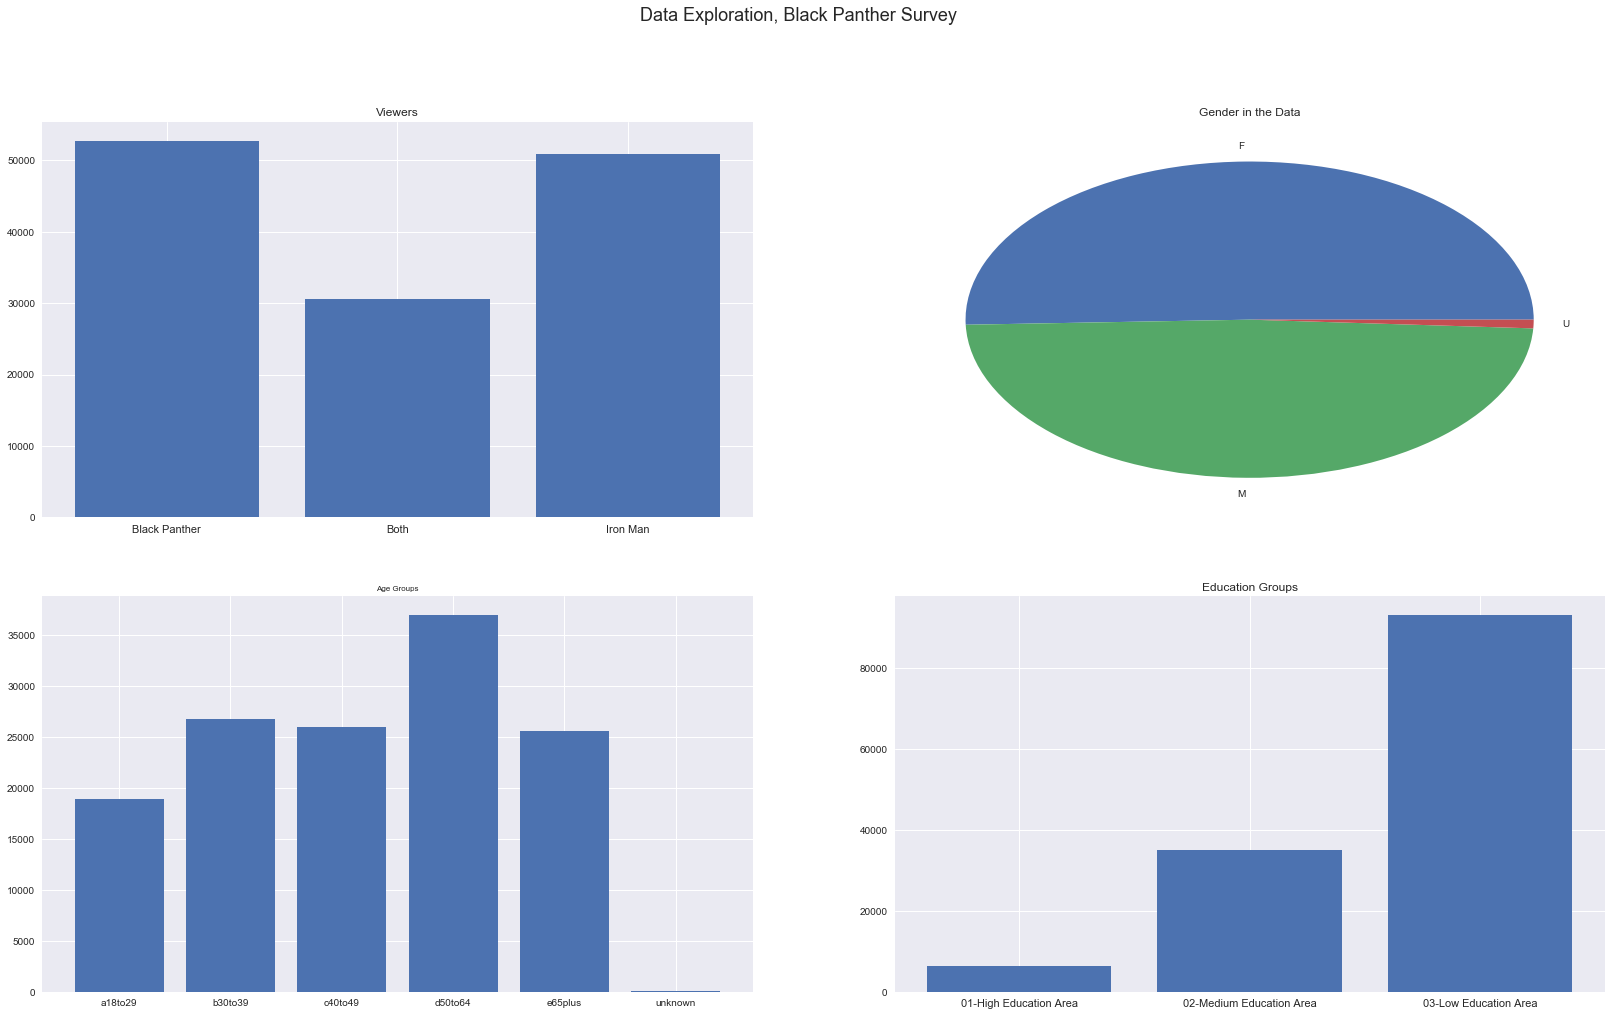

In [11]:
from matplotlib import pyplot as plt

plt.style.use('seaborn')

seen = df.groupby(['movie_seen']).count()
sex = df.groupby(['demo_sex']).count()
age = df.groupby(['demo_age_bucket']).count()
ed = df.groupby(['census_education_classification']).count()

# Tee up the plot
plt.figure(figsize=(28, 16))
plt.suptitle("Data Exploration, Black Panther Survey",
             fontsize=18)

# Define an ax variable from subplot:
ax1 = plt.subplot(2, 2, 1)
ax1.set_title("Viewers", fontsize=12)
ax1.set_xticks(range(3))
ax1.set_xticklabels(seen.index, fontsize=11)
#Draw it
ax1.bar(range(3), height=seen.ID.values)

ax2 = plt.subplot(2, 2, 2)
ax2.set_title("Gender in the Data", fontsize=12)
ax2.set_label(sex.index.values)
#Draw it
ax2.pie(sex.ID.values, labels=sex.index)

ax3 = plt.subplot(2, 2, 3)
ax3.set_title("Age Groups", fontsize=8)
ax3.set_xticklabels(age.index.values)
ax3.set_xticks(range(len(age.index)))
#Draw it
ax3.bar(range(len(age.index)), age.ID.values)

ax4 = plt.subplot(2, 2, 4)
ax4.set_title("Education Groups", fontsize=12)
ax4.set_xticks(range(len(ed.index)))
ax4.set_xticklabels(ed.index, fontsize=11)
#Draw it
ax4.bar(range(len(ed.index)), ed.ID.values)

#plt.savefig('explore.png')
plt.show()

These visualizations show the age, sex, education and viewership distributions in the data. Let's also see how some instrumental variables perform.

In [12]:
views = pd.get_dummies(df.movie_seen)
df[views.columns] = views
df['saw_bp'] = df['Both'] + df['Black Panther']

In [13]:
from sklearn.metrics import *
scored = df[df.support_black_panther_score != '(null)'].copy()
r2_score(scored['Black Panther'].values, 
         scored.support_black_panther_score.values)

-16380.48642627576

In [14]:
mean_absolute_error(scored['Black Panther'].values, 
         scored.support_black_panther_score.values)

51.534394758285408

Moving on, convert the values.

In [15]:
scored.support_black_panther_score= scored.support_black_panther_score.astype('float64')

In [16]:
perc = lambda x: 1 if x >= 50.0 else 0
scored['model_support'] = scored.support_black_panther_score.apply(perc);

In [17]:
mean_absolute_error(scored['Black Panther'].values, 
         scored.model_support.values)

0.1583260588182174

In [18]:
mean_absolute_error(scored['saw_bp'].values, 
         scored.model_support.values)

0.12731404834291563

In [22]:
r2_score(scored['saw_bp'].values, 
         scored.model_support.values)

0.4596346901926549

Unfortunately, it doesn't look like our scores track with viewership.

### Part 3: Evaluation
Let's see how the model performs! It would be nice if we could perform formal statistical tests on the model, but we didn't assign scores to the respondants.

In [23]:
raws = raw[pd.notnull(raw.disposition)]
raws = raws[raws.qsupport != '(null)']
raws = pd.merge(raws, weights, on="ID", how="left")

In [24]:
m_pct = scored[scored.demo_sex == 'M'
      ].groupby('model_support').sum().weight
f_pct = scored[scored.demo_sex == 'F'
      ].groupby('model_support').sum().weight
m_rpct = raws[raws.qsex == '1'
      ].groupby('qsupport').sum().weight
f_rpct = raws[raws.qsex == '2'
      ].groupby('qsupport').sum().weight

As shown below, our model estimated that a significantly higher percentage of both males and females would prefer Black Panther.

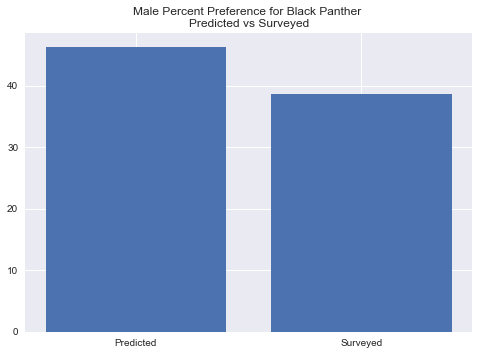

In [25]:

plt.title("Male Percent Preference for Black Panther \nPredicted vs Surveyed")
plt.xticks(range(2), ['Predicted', 'Surveyed'])
plt.bar(range(2), [m_pct[1]/m_pct.sum()*100, m_rpct[0]/m_rpct.sum()*100], 
        )
plt.show()

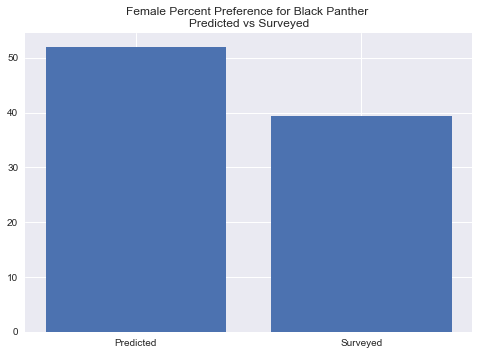

In [26]:
plt.title("Female Percent Preference for Black Panther \nPredicted vs Surveyed")
plt.xticks(range(2), ['Predicted', 'Surveyed'])
plt.bar(range(2), [f_pct[1]/f_pct.sum()*100, f_rpct[0]/f_rpct.sum()*100], 
        )
plt.show()

Given more time, other subgroup analyses may also be generated to illustrate how the original model over-estimates support for Black Panther. As females have a higher propensity to support the film in both the model set and the surveyed set, pursuing females in future campaigns is advisable while our team continues fine-tuning our model.

# Demo: SQL Queries on these datasets

In [17]:
import sqlite3
df['bp'] = df['Black Panther'].copy()
df['im'] = df['Iron Man'].copy()

In [43]:
raw.qsupport;

In [19]:
tables = [('raw', raw), ('df', df), ('weight', weights)]

con = sqlite3.connect("databs.db")
cur = con.cursor()

for name, i in tables:
    i.to_sql(name, con, index=i.index)

c:\users\cdl\anaconda3\lib\site-packages\pandas\core\generic.py:1201: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


The percent of weighted respondents who’ve seen either Black Panther, Iron Man or both movies.

In [ ]:
bp_per = cur.execute("""
SELECT bp, (Count(bp)* 100 / (SELECT Count(*) FROM df)) as Score
FROM df
WHERE df.ID IN 
    (SELECT ID FROM weight)
GROUP BY bp
""")
im_per = cur.execute("""
SELECT im, (Count(im)* 100 / (SELECT Count(*) FROM df)) as Score
FROM df
WHERE df.ID IN 
    (SELECT ID FROM weight)
GROUP BY im
""")
both_per = cur.execute("""
SELECT both, (Count(both)* 100 / (SELECT Count(*) FROM df)) as Score
FROM df
WHERE df.ID IN 
    (SELECT ID FROM weight)
GROUP BY both
""")

  The weighted percent of people who’ve seen each movie who say they are going to buy Black Panther merchandise and will not buy Iron Man merchandise


In [ ]:
buy = cur.execute("""
SELECT Count(*)
FROM df
LEFT JOIN raw df ON df.ID = raw.ID 
    AND qsupport = 1 
    AND both = 1
""")

The number of people with movie preference scores over 80 who are more likely to buy Iron Man merchandise.

In [ ]:
conflicted = cur.execute("""
SELECT Count(*) FROM raw 
WHERE qsupport = 2
LEFT JOIN df raw ON df.ID = raw.ID
    AND df.support_black_panther_score >= 80
""")